In [47]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

instruments = ['BTCUSD', 'SPY.USUSD', 'VXX.USUSD', 'XAUUSD']
def read_and_clean_data(ticker, timeframe):
    askfilename = "raw_data/" + ticker + "_Candlestick_1_" + timeframe + "_ASK_01.01.2022-12.03.2022.csv"
    bidfilename = "raw_data/" + ticker + "_Candlestick_1_" + timeframe + "_BID_01.01.2022-12.03.2022.csv"
    askdf = pd.read_csv(askfilename).add_prefix('ask_')
    biddf = pd.read_csv(bidfilename).add_prefix('bid_')
    df = askdf.join(biddf, lsuffix='ask_Gmt time', rsuffix='bid_Gmt time')
    df["open"] = ( df.ask_Open + df.bid_Open ) / 2
    df["close"] = ( df.ask_Close+ df.bid_Close ) / 2
    df["price"] = ( df.open + df.close ) / 2
    df = df[["ask_Gmt time", 'price']]
    
    df = df.rename({"ask_Gmt time": "time", "price": ticker[:3] + "_price"}, axis = 1)
    df.time = pd.to_datetime(df.time,dayfirst =True)
    df.time = df.time.dt.tz_localize(None)

    return df

def get_full_data(timeframe):
    dfs_to_join = [read_and_clean_data(i, timeframe) for i in instruments]
    df = reduce(lambda left,right: pd.merge(left,right,on='time'), dfs_to_join)

    return df

def clean_binance_data(filename):
    df = pd.read_csv(filename, parse_dates = ['date'])
    df["XRP_price"] = ( df.open + df.close ) / 2
    df = df[['date', 'XRP_price']]
    
    return df

def plotnormed(filename, pltname):
    df = pd.read_csv(filename, parse_dates = ['time']).set_index('time')
    print(df.shape)
    for i in df.columns:
        col = df[i]
        df[i] = (col - col.min()) / (col.max() - col.min())
    
    ax = df.plot(figsize = (10, 5))
    ax.set(xlabel='Day', ylabel='Price (normalized)')
    plt.savefig('images/' + pltname, format = "pdf", dpi = 300,bbox_inches='tight')
    plt.show()

In [12]:
tweets = pd.read_csv('raw_data/xrp_tweets.csv', parse_dates = True)
tweets["time"] = pd.to_datetime(tweets.timestamp, infer_datetime_format=True, utc = True)
tweets.time = tweets.time.dt.tz_localize(None)
tweets.time = tweets.time.dt.floor("min")
tweets = tweets.drop(['timestamp'], axis = 1)
tweets.to_csv('raw_data/tweets.csv', index = False)
tweets.head()

,text,time
0,$XRP.X,2022-01-07 16:07:00
1,$XRP.X https://www.sec.gov/news/press-release/...,2022-01-07 16:07:00
2,$XRP.X This is a golden opportunity for us mul...,2022-01-07 16:08:00
3,$XRP.X $ETH.X $BTC.X $ACH.X $HBAR.X ”LETS GO C...,2022-01-07 16:16:00
4,$XRP.X $BTC.X $SPY I was looking for Biden’s l...,2022-01-07 16:19:00


In [13]:
mintime = min(tweets.time)
maxtime = max(tweets.time)
mintime, maxtime

(Timestamp('2022-01-07 00:01:00'), Timestamp('2022-02-28 23:52:00'))

In [14]:
day = get_full_data("D")
print(day.shape)
xrpday = clean_binance_data("raw_data/Binance_XRPUSDT_minute.csv")
day = day.join(xrpday, lsuffix='time', rsuffix='date')
day = day.drop(['date'], axis = 1)
print(day.shape)
day = day[(day.time >= "2022-01-07") & (day.time <= "2022-03-02")].reset_index(drop = True)
print(day.shape)
day.to_csv('raw_data/day.csv', index = False)
day.head()

(71, 5)
(71, 6)
(55, 6)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-07,42323.75,467.0225,19.080,1793.90675,0.76155
1,2022-01-08,41620.75,466.1150,18.820,1796.37500,0.76140
2,2022-01-09,41777.50,466.1150,18.820,1795.09750,0.76160
3,2022-01-10,41845.25,464.0800,19.020,1798.24325,0.76145
4,2022-01-11,42282.75,467.4850,18.265,1811.06075,0.76130


(55, 5)


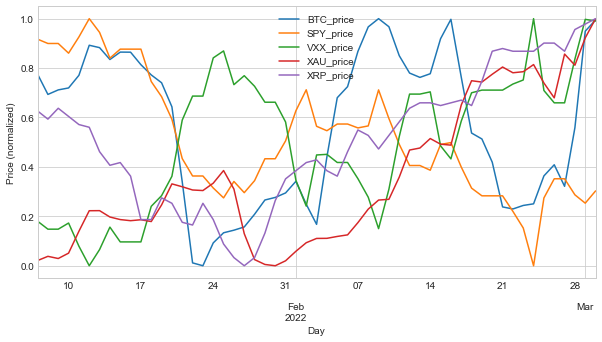

In [48]:
plotnormed("raw_data/day.csv", 'day_prices_normalized.pdf')

In [15]:
hour = get_full_data("Hour")
print(hour.shape)
xrphour = clean_binance_data("raw_data/Binance_XRPUSDT_1h.csv")
hour = hour.join(xrphour, lsuffix='time', rsuffix='date')
hour = hour.drop(['date'], axis = 1)
print(hour.shape)
hour = hour[(hour.time >= mintime) & (hour.time <= maxtime)].reset_index(drop = True)
print(hour.shape)
hour.to_csv('raw_data/hour.csv', index = False)
hour.head()

(1704, 5)
(1704, 6)
(1271, 6)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-07 01:00:00,42891.00,467.965,19.385,1791.39075,0.72155
1,2022-01-07 02:00:00,42898.00,467.965,19.385,1791.21500,0.72175
2,2022-01-07 03:00:00,42297.00,467.965,19.385,1792.26825,0.71825
3,2022-01-07 04:00:00,41748.25,467.965,19.385,1792.75150,0.71385
4,2022-01-07 05:00:00,41767.75,467.965,19.385,1791.73325,0.71880


(1271, 5)


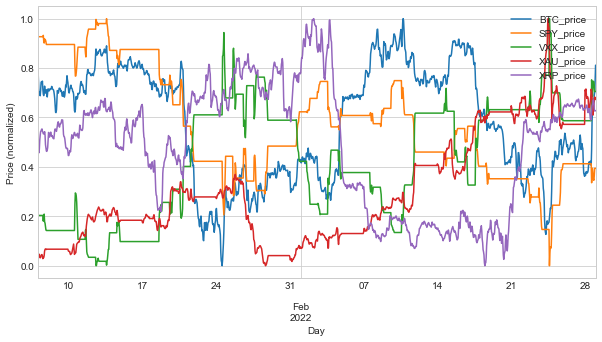

In [49]:
plotnormed("raw_data/hour.csv", 'hour_prices_normalized.pdf')

In [16]:
minute = get_full_data("M")
print(minute.shape)
xrpminute = clean_binance_data("raw_data/Binance_XRPUSDT_minute.csv")
minute = minute.join(xrpminute, lsuffix='time', rsuffix='date')
minute = minute.drop(['date'], axis = 1)
print(minute.shape)
minute = minute[(minute.time >= mintime) & (minute.time <= maxtime)].reset_index(drop = True)
print(minute.shape)
minute.to_csv('raw_data/minute.csv', index = False)
minute.head()

(102240, 5)
(102240, 6)
(76312, 6)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-07 00:01:00,43111.50,467.965,19.385,1791.5250,0.72640
1,2022-01-07 00:02:00,43107.25,467.965,19.385,1791.4625,0.72640
2,2022-01-07 00:03:00,43112.75,467.965,19.385,1791.5325,0.72645
3,2022-01-07 00:04:00,43091.25,467.965,19.385,1791.6325,0.72665
4,2022-01-07 00:05:00,43080.50,467.965,19.385,1791.7625,0.72665


(76312, 5)


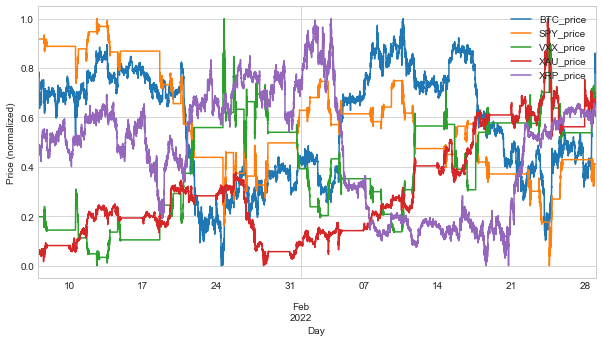

In [50]:
plotnormed("raw_data/minute.csv", 'minute_prices_normalized.pdf')